<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v4_apptom_less_weight_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset 
!kaggle datasets download -d manjuphoenix/appledataset

100% 922M/923M [00:31<00:00, 40.3MB/s]
100% 923M/923M [00:32<00:00, 30.2MB/s]
100% 333M/333M [00:11<00:00, 38.1MB/s]
100% 333M/333M [00:11<00:00, 30.3MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [6]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [7]:
!sudo mkdir /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset
!sudo cp -rf /content/Apple/* /content/dataset

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a validation set is: 27392
The number of images in a test set is: 5504
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [9]:
from PIL import Image
from pathlib import Path
from torch.autograd import Variable

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()

model = model.to(device)
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v4_tomato.pk1'))
model.load_state_dict(checkpoint)
model = model.to(device)

In [10]:
# !pip install torch-summary
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
         LeakyReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 130, 130]           4,640
         LeakyReLU-5         [-1, 32, 130, 130]               0
         MaxPool2d-6           [-1, 32, 65, 65]               0
            Linear-7                  [-1, 100]      13,520,100
            Linear-8                    [-1, 8]             808
Total params: 13,526,764
Trainable params: 13,526,764
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 27.28
Params size (MB): 51.60
Estimated Total Size (MB): 79.63
----------------------------------------------------------------


In [11]:
# model.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
model.fc2 = nn.Linear(100, 12)

In [12]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=12, bias=True)
)

In [13]:


class EarlyStopping():
  """ Early stopping is used to stop the training process to avoid overfitting of the model when the loss does not improve after certain epochs"""
  def __init__(self, patience=6, min_delta=0):
      """
      Parameters:
      Patience: Number of epochs to wait before stopping when the loss is not improving
      min_delta: Minimum difference between new loss and the old loss for new loss to be considered as an improvement
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print("INFO: Early Stopping")
        self.early_stop = True

In [14]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
    print('\nEpoch : %d'%epoch)
    total_loss=0    
    correct=0
    total=0

    model.train()
    for data in tqdm(dataloader):
        inputs,labels=data[0].to(device),data[1].to(device)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    loss=total_loss/len(dataloader)
    accuracy=100.*correct/total
    
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.4f | Accuracy: %.4f'%(loss,accuracy))
    return loss, accuracy

In [15]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()
    total_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= loss_fn(outputs,labels)
            total_loss+=loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        loss=total_loss/len(dataloader)
        accuracy=100.*correct/total
        losses['val'].append(loss)
        accuracies['val'].append(accuracy)
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 
    return loss, accuracy

In [16]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [17]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=100
early_stopping = EarlyStopping()
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model,loss_fn,train_loader,optimizer_ft,epoch)
  val_loss, val_accuracy = test(model,loss_fn,val_loader,epoch)
  early_stopping(val_loss)
  if early_stopping.early_stop:
    break


Epoch : 1


100%|██████████| 3993/3993 [05:43<00:00, 11.62it/s]


Train Loss: 2.1147 | Accuracy: 30.4130


100%|██████████| 856/856 [01:11<00:00, 11.94it/s]


Test Loss: 1.763 | Accuracy: 44.541

Epoch : 2


100%|██████████| 3993/3993 [05:46<00:00, 11.54it/s]


Train Loss: 1.5888 | Accuracy: 52.4828


100%|██████████| 856/856 [01:12<00:00, 11.82it/s]


Test Loss: 1.460 | Accuracy: 56.661

Epoch : 3


100%|██████████| 3993/3993 [05:48<00:00, 11.47it/s]


Train Loss: 1.3650 | Accuracy: 59.9281


100%|██████████| 856/856 [01:10<00:00, 12.14it/s]


Test Loss: 1.292 | Accuracy: 61.548

Epoch : 4


100%|██████████| 3993/3993 [05:47<00:00, 11.49it/s]


Train Loss: 1.2402 | Accuracy: 62.9518


100%|██████████| 856/856 [01:10<00:00, 12.09it/s]


Test Loss: 1.195 | Accuracy: 63.703

Epoch : 5


100%|██████████| 3993/3993 [05:46<00:00, 11.51it/s]


Train Loss: 1.1509 | Accuracy: 64.9478


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 1.120 | Accuracy: 65.376

Epoch : 6


100%|██████████| 3993/3993 [05:45<00:00, 11.57it/s]


Train Loss: 1.0940 | Accuracy: 65.9004


100%|██████████| 856/856 [01:11<00:00, 11.92it/s]


Test Loss: 1.070 | Accuracy: 66.282

Epoch : 7


100%|██████████| 3993/3993 [05:45<00:00, 11.57it/s]


Train Loss: 1.0491 | Accuracy: 66.8545


100%|██████████| 856/856 [01:10<00:00, 12.11it/s]


Test Loss: 1.029 | Accuracy: 67.009

Epoch : 8


100%|██████████| 3993/3993 [05:45<00:00, 11.54it/s]


Train Loss: 1.0127 | Accuracy: 67.7899


100%|██████████| 856/856 [01:10<00:00, 12.19it/s]


Test Loss: 0.999 | Accuracy: 68.145

Epoch : 9


100%|██████████| 3993/3993 [05:46<00:00, 11.53it/s]


Train Loss: 0.9825 | Accuracy: 68.4372


100%|██████████| 856/856 [01:11<00:00, 12.02it/s]


Test Loss: 0.973 | Accuracy: 68.923

Epoch : 10


100%|██████████| 3993/3993 [05:44<00:00, 11.59it/s]


Train Loss: 0.9520 | Accuracy: 69.2105


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]


Test Loss: 0.947 | Accuracy: 69.321

Epoch : 11


100%|██████████| 3993/3993 [05:45<00:00, 11.56it/s]


Train Loss: 0.9334 | Accuracy: 69.8508


100%|██████████| 856/856 [01:11<00:00, 11.97it/s]


Test Loss: 0.934 | Accuracy: 69.445

Epoch : 12


100%|██████████| 3993/3993 [05:46<00:00, 11.53it/s]


Train Loss: 0.9111 | Accuracy: 70.3228


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.906 | Accuracy: 70.607

Epoch : 13


100%|██████████| 3993/3993 [05:45<00:00, 11.54it/s]


Train Loss: 0.8996 | Accuracy: 70.6954


100%|██████████| 856/856 [01:11<00:00, 11.97it/s]


Test Loss: 0.893 | Accuracy: 70.808

Epoch : 14


100%|██████████| 3993/3993 [05:45<00:00, 11.57it/s]


Train Loss: 0.8829 | Accuracy: 71.2550


100%|██████████| 856/856 [01:09<00:00, 12.26it/s]


Test Loss: 0.878 | Accuracy: 71.202

Epoch : 15


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.8686 | Accuracy: 71.7176


100%|██████████| 856/856 [01:10<00:00, 12.23it/s]


Test Loss: 0.875 | Accuracy: 71.469

Epoch : 16


100%|██████████| 3993/3993 [05:41<00:00, 11.70it/s]


Train Loss: 0.8569 | Accuracy: 72.0464


100%|██████████| 856/856 [01:10<00:00, 12.14it/s]


Test Loss: 0.853 | Accuracy: 72.064

Epoch : 17


100%|██████████| 3993/3993 [05:42<00:00, 11.67it/s]


Train Loss: 0.8429 | Accuracy: 72.4166


100%|██████████| 856/856 [01:09<00:00, 12.26it/s]


Test Loss: 0.841 | Accuracy: 72.356

Epoch : 18


100%|██████████| 3993/3993 [05:43<00:00, 11.62it/s]


Train Loss: 0.8340 | Accuracy: 72.8385


100%|██████████| 856/856 [01:10<00:00, 12.11it/s]


Test Loss: 0.833 | Accuracy: 72.751

Epoch : 19


100%|██████████| 3993/3993 [05:46<00:00, 11.52it/s]


Train Loss: 0.8205 | Accuracy: 73.1672


100%|██████████| 856/856 [01:10<00:00, 12.11it/s]


Test Loss: 0.830 | Accuracy: 72.619

Epoch : 20


100%|██████████| 3993/3993 [05:41<00:00, 11.68it/s]


Train Loss: 0.8135 | Accuracy: 73.2486


100%|██████████| 856/856 [01:09<00:00, 12.27it/s]


Test Loss: 0.820 | Accuracy: 72.857

Epoch : 21


100%|██████████| 3993/3993 [05:41<00:00, 11.68it/s]


Train Loss: 0.8040 | Accuracy: 73.7238


100%|██████████| 856/856 [01:09<00:00, 12.25it/s]


Test Loss: 0.810 | Accuracy: 73.054

Epoch : 22


100%|██████████| 3993/3993 [05:41<00:00, 11.70it/s]


Train Loss: 0.7945 | Accuracy: 73.9382


100%|██████████| 856/856 [01:11<00:00, 12.03it/s]


Test Loss: 0.800 | Accuracy: 73.211

Epoch : 23


100%|██████████| 3993/3993 [05:44<00:00, 11.60it/s]


Train Loss: 0.7894 | Accuracy: 73.9875


100%|██████████| 856/856 [01:10<00:00, 12.09it/s]


Test Loss: 0.786 | Accuracy: 73.931

Epoch : 24


100%|██████████| 3993/3993 [05:42<00:00, 11.64it/s]


Train Loss: 0.7827 | Accuracy: 74.4196


100%|██████████| 856/856 [01:10<00:00, 12.22it/s]


Test Loss: 0.783 | Accuracy: 74.175

Epoch : 25


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.7757 | Accuracy: 74.5855


100%|██████████| 856/856 [01:09<00:00, 12.25it/s]


Test Loss: 0.780 | Accuracy: 74.048

Epoch : 26


100%|██████████| 3993/3993 [05:42<00:00, 11.67it/s]


Train Loss: 0.7659 | Accuracy: 74.9362


100%|██████████| 856/856 [01:11<00:00, 11.95it/s]


Test Loss: 0.772 | Accuracy: 74.610

Epoch : 27


100%|██████████| 3993/3993 [05:42<00:00, 11.67it/s]


Train Loss: 0.7614 | Accuracy: 75.0380


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.765 | Accuracy: 74.559

Epoch : 28


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.7535 | Accuracy: 75.2610


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]


Test Loss: 0.761 | Accuracy: 75.227

Epoch : 29


100%|██████████| 3993/3993 [05:41<00:00, 11.69it/s]


Train Loss: 0.7541 | Accuracy: 75.2892


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 0.758 | Accuracy: 75.129

Epoch : 30


100%|██████████| 3993/3993 [05:41<00:00, 11.70it/s]


Train Loss: 0.7414 | Accuracy: 75.6266


100%|██████████| 856/856 [01:10<00:00, 12.06it/s]


Test Loss: 0.750 | Accuracy: 75.249

Epoch : 31


100%|██████████| 3993/3993 [05:41<00:00, 11.69it/s]


Train Loss: 0.7416 | Accuracy: 75.7189


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.749 | Accuracy: 75.107

Epoch : 32


100%|██████████| 3993/3993 [05:42<00:00, 11.65it/s]


Train Loss: 0.7333 | Accuracy: 75.9240


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]


Test Loss: 0.743 | Accuracy: 75.651

Epoch : 33


100%|██████████| 3993/3993 [05:43<00:00, 11.63it/s]


Train Loss: 0.7326 | Accuracy: 76.0853


100%|██████████| 856/856 [01:09<00:00, 12.29it/s]


Test Loss: 0.732 | Accuracy: 76.159

Epoch : 34


100%|██████████| 3993/3993 [05:41<00:00, 11.69it/s]


Train Loss: 0.7244 | Accuracy: 76.2731


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]


Test Loss: 0.733 | Accuracy: 75.746
INFO: Early stopping counter 1 of 6

Epoch : 35


100%|██████████| 3993/3993 [05:39<00:00, 11.78it/s]


Train Loss: 0.7193 | Accuracy: 76.3976


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.726 | Accuracy: 75.929

Epoch : 36


100%|██████████| 3993/3993 [05:40<00:00, 11.73it/s]


Train Loss: 0.7175 | Accuracy: 76.4508


100%|██████████| 856/856 [01:09<00:00, 12.34it/s]


Test Loss: 0.723 | Accuracy: 76.360

Epoch : 37


100%|██████████| 3993/3993 [05:40<00:00, 11.71it/s]


Train Loss: 0.7100 | Accuracy: 76.8461


100%|██████████| 856/856 [01:10<00:00, 12.18it/s]


Test Loss: 0.721 | Accuracy: 76.250

Epoch : 38


100%|██████████| 3993/3993 [05:38<00:00, 11.81it/s]


Train Loss: 0.7128 | Accuracy: 76.7177


100%|██████████| 856/856 [01:09<00:00, 12.23it/s]


Test Loss: 0.726 | Accuracy: 75.947
INFO: Early stopping counter 1 of 6

Epoch : 39


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.7056 | Accuracy: 76.9400


100%|██████████| 856/856 [01:09<00:00, 12.40it/s]


Test Loss: 0.717 | Accuracy: 76.670

Epoch : 40


100%|██████████| 3993/3993 [05:36<00:00, 11.86it/s]


Train Loss: 0.7005 | Accuracy: 77.1459


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]


Test Loss: 0.705 | Accuracy: 77.116

Epoch : 41


100%|██████████| 3993/3993 [05:36<00:00, 11.86it/s]


Train Loss: 0.6983 | Accuracy: 77.3415


100%|██████████| 856/856 [01:08<00:00, 12.41it/s]


Test Loss: 0.708 | Accuracy: 77.032
INFO: Early stopping counter 1 of 6

Epoch : 42


100%|██████████| 3993/3993 [05:37<00:00, 11.81it/s]


Train Loss: 0.6900 | Accuracy: 77.4636


100%|██████████| 856/856 [01:10<00:00, 12.20it/s]


Test Loss: 0.700 | Accuracy: 77.057

Epoch : 43


100%|██████████| 3993/3993 [05:41<00:00, 11.70it/s]


Train Loss: 0.6909 | Accuracy: 77.3353


100%|██████████| 856/856 [01:09<00:00, 12.28it/s]


Test Loss: 0.693 | Accuracy: 77.324

Epoch : 44


100%|██████████| 3993/3993 [05:40<00:00, 11.73it/s]


Train Loss: 0.6819 | Accuracy: 77.9943


100%|██████████| 856/856 [01:11<00:00, 11.95it/s]


Test Loss: 0.693 | Accuracy: 77.459

Epoch : 45


100%|██████████| 3993/3993 [05:39<00:00, 11.75it/s]


Train Loss: 0.6836 | Accuracy: 77.8636


100%|██████████| 856/856 [01:09<00:00, 12.36it/s]


Test Loss: 0.695 | Accuracy: 77.266
INFO: Early stopping counter 1 of 6

Epoch : 46


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.6825 | Accuracy: 77.7658


100%|██████████| 856/856 [01:10<00:00, 12.15it/s]


Test Loss: 0.684 | Accuracy: 77.550

Epoch : 47


100%|██████████| 3993/3993 [05:40<00:00, 11.74it/s]


Train Loss: 0.6748 | Accuracy: 78.0898


100%|██████████| 856/856 [01:08<00:00, 12.54it/s]


Test Loss: 0.688 | Accuracy: 77.510
INFO: Early stopping counter 1 of 6

Epoch : 48


100%|██████████| 3993/3993 [05:40<00:00, 11.73it/s]


Train Loss: 0.6715 | Accuracy: 78.2221


100%|██████████| 856/856 [01:10<00:00, 12.19it/s]


Test Loss: 0.680 | Accuracy: 77.697

Epoch : 49


100%|██████████| 3993/3993 [05:38<00:00, 11.78it/s]


Train Loss: 0.6673 | Accuracy: 78.2785


100%|██████████| 856/856 [01:08<00:00, 12.47it/s]


Test Loss: 0.683 | Accuracy: 77.773
INFO: Early stopping counter 1 of 6

Epoch : 50


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.6644 | Accuracy: 78.2612


100%|██████████| 856/856 [01:09<00:00, 12.29it/s]


Test Loss: 0.680 | Accuracy: 77.879
INFO: Early stopping counter 2 of 6

Epoch : 51


100%|██████████| 3993/3993 [05:39<00:00, 11.76it/s]


Train Loss: 0.6652 | Accuracy: 78.3552


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.674 | Accuracy: 77.861

Epoch : 52


100%|██████████| 3993/3993 [05:38<00:00, 11.81it/s]


Train Loss: 0.6622 | Accuracy: 78.5031


100%|██████████| 856/856 [01:09<00:00, 12.28it/s]


Test Loss: 0.676 | Accuracy: 77.839
INFO: Early stopping counter 1 of 6

Epoch : 53


100%|██████████| 3993/3993 [05:40<00:00, 11.74it/s]


Train Loss: 0.6607 | Accuracy: 78.4436


100%|██████████| 856/856 [01:08<00:00, 12.43it/s]


Test Loss: 0.663 | Accuracy: 78.252

Epoch : 54


100%|██████████| 3993/3993 [05:36<00:00, 11.86it/s]


Train Loss: 0.6572 | Accuracy: 78.6385


100%|██████████| 856/856 [01:09<00:00, 12.35it/s]


Test Loss: 0.671 | Accuracy: 77.949
INFO: Early stopping counter 1 of 6

Epoch : 55


100%|██████████| 3993/3993 [05:39<00:00, 11.77it/s]


Train Loss: 0.6548 | Accuracy: 78.7035


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 0.659 | Accuracy: 78.416

Epoch : 56


100%|██████████| 3993/3993 [05:39<00:00, 11.78it/s]


Train Loss: 0.6504 | Accuracy: 78.8170


100%|██████████| 856/856 [01:10<00:00, 12.19it/s]


Test Loss: 0.664 | Accuracy: 78.329
INFO: Early stopping counter 1 of 6

Epoch : 57


100%|██████████| 3993/3993 [05:39<00:00, 11.77it/s]


Train Loss: 0.6510 | Accuracy: 78.8592


100%|██████████| 856/856 [01:09<00:00, 12.26it/s]


Test Loss: 0.662 | Accuracy: 78.160
INFO: Early stopping counter 2 of 6

Epoch : 58


100%|██████████| 3993/3993 [05:39<00:00, 11.76it/s]


Train Loss: 0.6472 | Accuracy: 78.8240


100%|██████████| 856/856 [01:09<00:00, 12.34it/s]


Test Loss: 0.654 | Accuracy: 78.650

Epoch : 59


100%|██████████| 3993/3993 [05:37<00:00, 11.83it/s]


Train Loss: 0.6398 | Accuracy: 79.2819


100%|██████████| 856/856 [01:09<00:00, 12.33it/s]


Test Loss: 0.655 | Accuracy: 78.592
INFO: Early stopping counter 1 of 6

Epoch : 60


100%|██████████| 3993/3993 [05:39<00:00, 11.77it/s]


Train Loss: 0.6465 | Accuracy: 78.8287


100%|██████████| 856/856 [01:09<00:00, 12.35it/s]


Test Loss: 0.653 | Accuracy: 78.478

Epoch : 61


100%|██████████| 3993/3993 [05:41<00:00, 11.70it/s]


Train Loss: 0.6390 | Accuracy: 79.1402


100%|██████████| 856/856 [01:10<00:00, 12.13it/s]


Test Loss: 0.653 | Accuracy: 78.760
INFO: Early stopping counter 1 of 6

Epoch : 62


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.6343 | Accuracy: 79.4001


100%|██████████| 856/856 [01:10<00:00, 12.18it/s]


Test Loss: 0.650 | Accuracy: 78.851

Epoch : 63


100%|██████████| 3993/3993 [05:43<00:00, 11.63it/s]


Train Loss: 0.6305 | Accuracy: 79.3743


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 0.647 | Accuracy: 78.811

Epoch : 64


100%|██████████| 3993/3993 [05:38<00:00, 11.78it/s]


Train Loss: 0.6358 | Accuracy: 79.1254


100%|██████████| 856/856 [01:09<00:00, 12.30it/s]


Test Loss: 0.646 | Accuracy: 78.661

Epoch : 65


100%|██████████| 3993/3993 [05:46<00:00, 11.51it/s]


Train Loss: 0.6339 | Accuracy: 79.2530


100%|██████████| 856/856 [01:14<00:00, 11.42it/s]


Test Loss: 0.638 | Accuracy: 79.001

Epoch : 66


100%|██████████| 3993/3993 [05:40<00:00, 11.74it/s]


Train Loss: 0.6288 | Accuracy: 79.4596


100%|██████████| 856/856 [01:09<00:00, 12.39it/s]


Test Loss: 0.639 | Accuracy: 79.026
INFO: Early stopping counter 1 of 6

Epoch : 67


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.6315 | Accuracy: 79.4737


100%|██████████| 856/856 [01:09<00:00, 12.32it/s]


Test Loss: 0.639 | Accuracy: 79.030
INFO: Early stopping counter 2 of 6

Epoch : 68


100%|██████████| 3993/3993 [05:39<00:00, 11.77it/s]


Train Loss: 0.6232 | Accuracy: 79.7163


100%|██████████| 856/856 [01:10<00:00, 12.16it/s]


Test Loss: 0.644 | Accuracy: 78.844
INFO: Early stopping counter 3 of 6

Epoch : 69


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.6238 | Accuracy: 79.7022


100%|██████████| 856/856 [01:09<00:00, 12.30it/s]


Test Loss: 0.639 | Accuracy: 79.366
INFO: Early stopping counter 4 of 6

Epoch : 70


100%|██████████| 3993/3993 [05:39<00:00, 11.77it/s]


Train Loss: 0.6253 | Accuracy: 79.5966


100%|██████████| 856/856 [01:08<00:00, 12.41it/s]


Test Loss: 0.629 | Accuracy: 79.465

Epoch : 71


100%|██████████| 3993/3993 [05:37<00:00, 11.82it/s]


Train Loss: 0.6222 | Accuracy: 79.7226


100%|██████████| 856/856 [01:10<00:00, 12.20it/s]


Test Loss: 0.635 | Accuracy: 79.023
INFO: Early stopping counter 1 of 6

Epoch : 72


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.6201 | Accuracy: 79.7437


100%|██████████| 856/856 [01:10<00:00, 12.15it/s]


Test Loss: 0.629 | Accuracy: 79.275
INFO: Early stopping counter 2 of 6

Epoch : 73


100%|██████████| 3993/3993 [05:40<00:00, 11.72it/s]


Train Loss: 0.6147 | Accuracy: 79.8369


100%|██████████| 856/856 [01:10<00:00, 12.18it/s]


Test Loss: 0.631 | Accuracy: 79.307
INFO: Early stopping counter 3 of 6

Epoch : 74


100%|██████████| 3993/3993 [05:46<00:00, 11.53it/s]


Train Loss: 0.6188 | Accuracy: 79.8862


100%|██████████| 856/856 [01:10<00:00, 12.20it/s]


Test Loss: 0.635 | Accuracy: 79.304
INFO: Early stopping counter 4 of 6

Epoch : 75


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.6137 | Accuracy: 80.0310


100%|██████████| 856/856 [01:10<00:00, 12.22it/s]


Test Loss: 0.622 | Accuracy: 79.636

Epoch : 76


100%|██████████| 3993/3993 [05:42<00:00, 11.67it/s]


Train Loss: 0.6091 | Accuracy: 80.0427


100%|██████████| 856/856 [01:09<00:00, 12.28it/s]


Test Loss: 0.630 | Accuracy: 79.307
INFO: Early stopping counter 1 of 6

Epoch : 77


100%|██████████| 3993/3993 [05:43<00:00, 11.63it/s]


Train Loss: 0.6166 | Accuracy: 79.9152


100%|██████████| 856/856 [01:25<00:00,  9.96it/s]


Test Loss: 0.624 | Accuracy: 79.541
INFO: Early stopping counter 2 of 6

Epoch : 78


100%|██████████| 3993/3993 [06:02<00:00, 11.03it/s]


Train Loss: 0.6082 | Accuracy: 80.2650


100%|██████████| 856/856 [01:13<00:00, 11.59it/s]


Test Loss: 0.621 | Accuracy: 79.490

Epoch : 79


100%|██████████| 3993/3993 [06:04<00:00, 10.96it/s]


Train Loss: 0.6090 | Accuracy: 80.1907


100%|██████████| 856/856 [01:14<00:00, 11.56it/s]


Test Loss: 0.616 | Accuracy: 79.881

Epoch : 80


100%|██████████| 3993/3993 [06:04<00:00, 10.97it/s]


Train Loss: 0.6041 | Accuracy: 80.2400


100%|██████████| 856/856 [01:14<00:00, 11.57it/s]


Test Loss: 0.619 | Accuracy: 79.563
INFO: Early stopping counter 1 of 6

Epoch : 81


100%|██████████| 3993/3993 [05:53<00:00, 11.28it/s]


Train Loss: 0.6009 | Accuracy: 80.4059


100%|██████████| 856/856 [01:12<00:00, 11.89it/s]


Test Loss: 0.625 | Accuracy: 79.563
INFO: Early stopping counter 2 of 6

Epoch : 82


100%|██████████| 3993/3993 [05:42<00:00, 11.66it/s]


Train Loss: 0.6070 | Accuracy: 80.2095


100%|██████████| 856/856 [01:10<00:00, 12.14it/s]


Test Loss: 0.625 | Accuracy: 79.413
INFO: Early stopping counter 3 of 6

Epoch : 83


100%|██████████| 3993/3993 [05:39<00:00, 11.75it/s]


Train Loss: 0.6026 | Accuracy: 80.2776


100%|██████████| 856/856 [01:09<00:00, 12.38it/s]


Test Loss: 0.622 | Accuracy: 79.508
INFO: Early stopping counter 4 of 6

Epoch : 84


100%|██████████| 3993/3993 [05:40<00:00, 11.71it/s]


Train Loss: 0.6031 | Accuracy: 80.4474


100%|██████████| 856/856 [01:10<00:00, 12.09it/s]


Test Loss: 0.612 | Accuracy: 79.906

Epoch : 85


100%|██████████| 3993/3993 [05:41<00:00, 11.69it/s]


Train Loss: 0.5983 | Accuracy: 80.4028


100%|██████████| 856/856 [01:09<00:00, 12.26it/s]


Test Loss: 0.611 | Accuracy: 80.085

Epoch : 86


100%|██████████| 3993/3993 [05:44<00:00, 11.60it/s]


Train Loss: 0.5967 | Accuracy: 80.4474


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 0.607 | Accuracy: 80.191

Epoch : 87


100%|██████████| 3993/3993 [05:45<00:00, 11.57it/s]


Train Loss: 0.5961 | Accuracy: 80.4999


100%|██████████| 856/856 [01:11<00:00, 11.95it/s]


Test Loss: 0.610 | Accuracy: 79.903
INFO: Early stopping counter 1 of 6

Epoch : 88


100%|██████████| 3993/3993 [05:44<00:00, 11.58it/s]


Train Loss: 0.5980 | Accuracy: 80.5218


100%|██████████| 856/856 [01:11<00:00, 12.03it/s]


Test Loss: 0.607 | Accuracy: 79.980
INFO: Early stopping counter 2 of 6

Epoch : 89


100%|██████████| 3993/3993 [05:43<00:00, 11.61it/s]


Train Loss: 0.5913 | Accuracy: 80.7394


100%|██████████| 856/856 [01:11<00:00, 12.01it/s]


Test Loss: 0.609 | Accuracy: 79.852
INFO: Early stopping counter 3 of 6

Epoch : 90


100%|██████████| 3993/3993 [05:44<00:00, 11.59it/s]


Train Loss: 0.5881 | Accuracy: 80.7722


100%|██████████| 856/856 [01:11<00:00, 12.00it/s]


Test Loss: 0.608 | Accuracy: 80.023
INFO: Early stopping counter 4 of 6

Epoch : 91


100%|██████████| 3993/3993 [05:45<00:00, 11.54it/s]


Train Loss: 0.5915 | Accuracy: 80.7308


100%|██████████| 856/856 [01:09<00:00, 12.23it/s]


Test Loss: 0.602 | Accuracy: 80.224

Epoch : 92


100%|██████████| 3993/3993 [05:48<00:00, 11.46it/s]


Train Loss: 0.5896 | Accuracy: 80.7464


100%|██████████| 856/856 [01:10<00:00, 12.13it/s]


Test Loss: 0.604 | Accuracy: 80.159
INFO: Early stopping counter 1 of 6

Epoch : 93


100%|██████████| 3993/3993 [05:45<00:00, 11.55it/s]


Train Loss: 0.5915 | Accuracy: 80.5961


100%|██████████| 856/856 [01:11<00:00, 12.03it/s]


Test Loss: 0.605 | Accuracy: 80.363
INFO: Early stopping counter 2 of 6

Epoch : 94


100%|██████████| 3993/3993 [05:46<00:00, 11.53it/s]


Train Loss: 0.5881 | Accuracy: 80.7206


100%|██████████| 856/856 [01:10<00:00, 12.07it/s]


Test Loss: 0.605 | Accuracy: 80.301
INFO: Early stopping counter 3 of 6

Epoch : 95


100%|██████████| 3993/3993 [05:44<00:00, 11.60it/s]


Train Loss: 0.5833 | Accuracy: 80.9734


100%|██████████| 856/856 [01:12<00:00, 11.88it/s]


Test Loss: 0.599 | Accuracy: 80.411

Epoch : 96


100%|██████████| 3993/3993 [05:44<00:00, 11.58it/s]


Train Loss: 0.5830 | Accuracy: 80.9037


100%|██████████| 856/856 [01:09<00:00, 12.25it/s]


Test Loss: 0.603 | Accuracy: 80.177
INFO: Early stopping counter 1 of 6

Epoch : 97


100%|██████████| 3993/3993 [05:46<00:00, 11.53it/s]


Train Loss: 0.5808 | Accuracy: 80.9867


100%|██████████| 856/856 [01:10<00:00, 12.18it/s]


Test Loss: 0.596 | Accuracy: 80.495

Epoch : 98


100%|██████████| 3993/3993 [05:47<00:00, 11.48it/s]


Train Loss: 0.5799 | Accuracy: 80.9397


100%|██████████| 856/856 [01:09<00:00, 12.23it/s]


Test Loss: 0.593 | Accuracy: 80.516

Epoch : 99


100%|██████████| 3993/3993 [05:49<00:00, 11.43it/s]


Train Loss: 0.5795 | Accuracy: 81.0517


100%|██████████| 856/856 [01:10<00:00, 12.20it/s]


Test Loss: 0.600 | Accuracy: 80.129
INFO: Early stopping counter 1 of 6

Epoch : 100


100%|██████████| 3993/3993 [05:47<00:00, 11.48it/s]


Train Loss: 0.5758 | Accuracy: 81.1793


100%|██████████| 856/856 [01:10<00:00, 12.17it/s]

Test Loss: 0.593 | Accuracy: 80.703


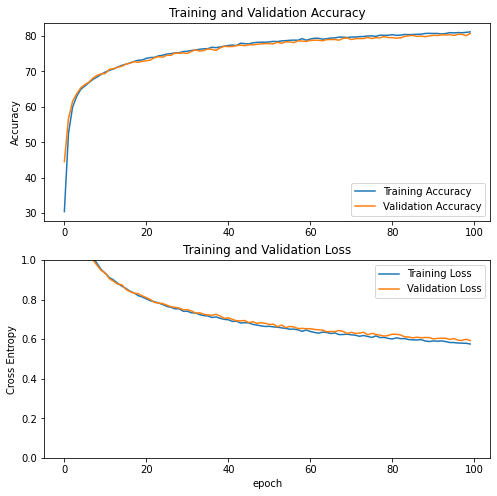

In [18]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

IndexError: ignored

In [ ]:
avg = 0
for i in range(12):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/12
print('Average accuracy = ', avg)

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v4_apptomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v4_apptomato_scripted.pt') # Save

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)